#### Предсказываем цену автомобиля

В папке лежит датасет Car details v3, в котором содержатся сведения об автомобилях, их характеристики и цены. Обучите модель линейной регрессии, которая будет предсказывать цену автомобиля по его характеристикам. 

Придется хорошенько поработать с характеристиками: это *творческая* часть задания. Во-первых, надо привести их в машиночитаемый вид, а во-вторых, можно посмотреть, как они коррелируют друг с другом и не нужно ли кого-то из них дропнуть или наоборот. 

*Примечание*: без работы над фичами за все дз - **0 баллов**. 

In [418]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [419]:
data = pd.read_csv('Car details v3.csv')
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [420]:
# Оставляем только первое слово в колонке 'name', предполагая, что это марка автомобиля
data['brand'] = data['name'].apply(lambda x: x.split()[0])
data.drop(['name'], axis=1, inplace=True)

data.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,Maruti
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,Skoda
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,Honda
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0,Hyundai
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,Maruti


In [421]:
set(data.owner)

{'First Owner',
 'Fourth & Above Owner',
 'Second Owner',
 'Test Drive Car',
 'Third Owner'}

In [422]:
set(data.seller_type)

{'Dealer', 'Individual', 'Trustmark Dealer'}

In [423]:
set(data.transmission)

{'Automatic', 'Manual'}

In [424]:
data.transmission = data.transmission.apply(lambda x: 1 if x == 'Automatic' else 0)

In [425]:
def map_owner(owner):
    dct = {
        'First Owner': 1,
        'Second Owner': 2,
        'Third Owner': 3,
        'Fourth & Above Owner': 4,
        'Test Drive Car': 0
    }
    return dct[owner]

def map_seller(seller):
    dct = {'Individual': 1, 'Dealer': 2, 'Trustmark Dealer': 3}
    return dct[seller]
    
data['owner'] = data['owner'].apply(map_owner)
data['seller_type'] = data['seller_type'].apply(map_seller)

In [426]:
# Извлекаем числовые значения из колонок 'mileage', 'engine' и 'max_power' 
data['mileage'] = data['mileage'].str.extract('(\d+\.\d+)').astype(float)
data['engine'] = data['engine'].str.extract('(\d+)').astype(float)
data['max_power'] = data['max_power'].str.extract('(\d+\.\d+|\d+)').astype(float)

In [427]:
data.isnull().sum()

year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        216
torque           222
seats            221
brand              0
dtype: int64

In [428]:
# Заполняем пропущенные значения в колонках 'mileage', 'engine', 'max_power' и 'seats' средними значениями
for column in ['mileage', 'engine', 'max_power', 'seats']:
    data[column].fillna(data[column].mean(), inplace=True)

In [429]:
# Извлекаем числовые значения крутящего момента и его единицы измерения, после чего преобразуем kgm в Nm
data['torque_num'] = data['torque'].str.extract('(\d+\.\d+|\d+)').astype(float)
data['torque_unit'] = data['torque'].apply(lambda x: 'Nm' if 'nm' in str(x).lower() else ('kgm' if 'kgm' in str(x).lower() else 'unknown'))
data['torque_nm'] = data.apply(lambda row: row['torque_num'] * 9.806 if row['torque_unit'] == 'kgm' else row['torque_num'], axis=1)
data['torque_nm'].fillna(data['torque_nm'].mean(), inplace=True)

data.drop(['torque', 'torque_num', 'torque_unit'], axis=1, inplace=True)
data.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,brand,torque_nm
0,2014,450000,145500,Diesel,1,0,1,23.40,1248.0,74.00,5.0,Maruti,190.0000
1,2014,370000,120000,Diesel,1,0,2,21.14,1498.0,103.52,5.0,Skoda,250.0000
2,2006,158000,140000,Petrol,1,0,3,17.70,1497.0,78.00,5.0,Honda,124.5362
3,2010,225000,127000,Diesel,1,0,1,23.00,1396.0,90.00,5.0,Hyundai,219.6544
4,2007,130000,120000,Petrol,1,0,1,16.10,1298.0,88.20,5.0,Maruti,112.7690


In [430]:
# One-hot encoding
data = pd.get_dummies(data, drop_first=True)

In [431]:
def evaluate_model(data, target_column, test_size=0.2, random_state=111):
    X = data.drop([target_column], axis=1)
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = LinearRegression()
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    rmse_test = mean_squared_error(y_test, pred_test) ** 0.5
    rmse_train = mean_squared_error(y_train, pred_train) ** 0.5

    print(f"RMSE Test: {rmse_test}, RMSE Train: {rmse_train}")

In [432]:
evaluate_model(data, 'selling_price')

RMSE Test: 314539.40634967724, RMSE Train: 319405.2114536824


<Axes: >

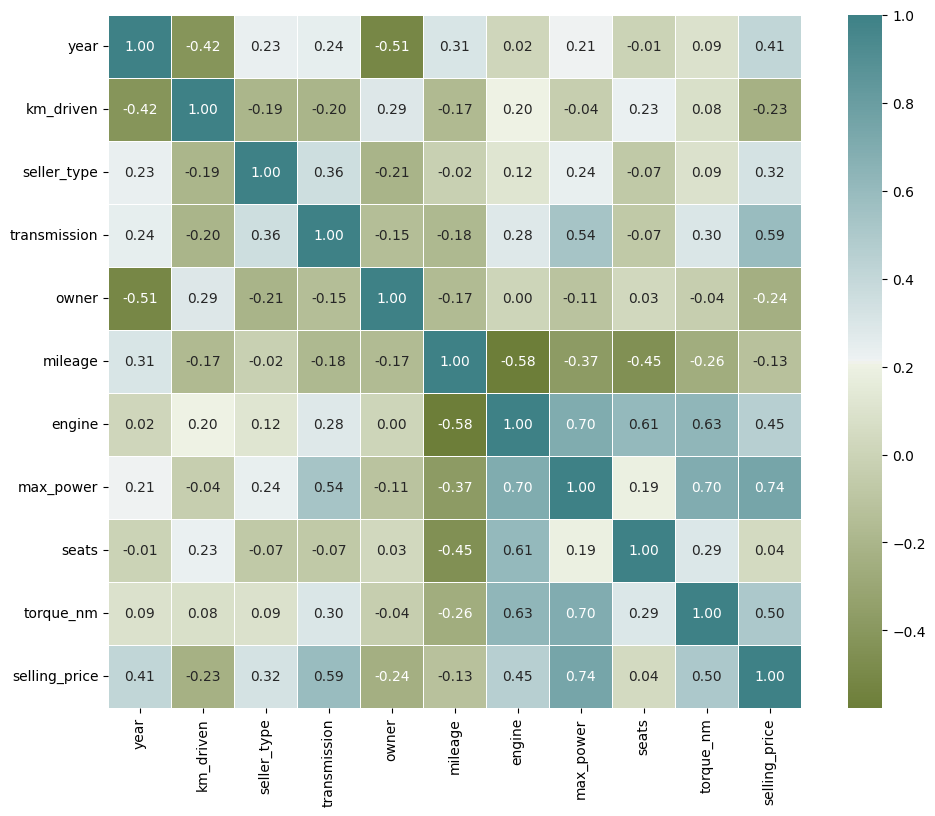

In [433]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

selected_features = ['year', 'km_driven', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats', 'torque_nm', 'selling_price']
corr = data[selected_features].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f',
            mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(100, 200, as_cmap=True), square=True)

Число сидений (seats) имеет относительно низкую корреляцию с целевой переменной (selling_price), поэтому я решил исключить seats из признаков, но это почти не повлияло на результат. 

In [434]:
data = data.drop(['seats'], axis=1)

In [435]:
evaluate_model(data, 'selling_price')

RMSE Test: 314543.97309454455, RMSE Train: 319405.34023907036


Максимальная мощность двигателя (max_power) и его объем (engine) имеют высокую корреляцию как между собой, так и с ценой автомобиля. 
Я попробовал создать новый признак power_to_engine_ratio, который представляет собой отношение мощности к объему двигателя и является показателем эффективности двигателя.
Новый признак слегка улучшает модель.

In [436]:
data['power_to_engine_ratio'] = data['max_power'] / data['engine']

In [437]:
evaluate_model(data, 'selling_price')

RMSE Test: 312551.96946804214, RMSE Train: 318052.83469634777
